In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from sklearn.decomposition import  PCA
import datasets

In [62]:
device = 'cpu'

In [2]:
ds = datasets.load_dataset("damlab/uniprot")['train']['sequence']
ds = ds[:485040] + ds[485043:500302] + ds[500303:]

Found cached dataset parquet (/home/danny/.cache/huggingface/datasets/damlab___parquet/damlab--uniprot-28c00e1433a53e45/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
context_length = 5
chars = sorted(list(set("".join(ds))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = -1
stoi['!'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', -1: '.', 0: '!'}


In [4]:
def make_dataset(seqs):
    X, y = [], []
    for seq in seqs:
        if len(seq) < context_length:
            continue
        pre = [0] * context_length
        post = [stoi[char] for char in seq[:context_length]]
        seqpp = seq + "."*context_length
        for i, ch in enumerate(seq):
            pre = pre[1:] + [stoi[seqpp[i]]]
            post = post[1:] + [stoi[seqpp[i+context_length]]]
            X.append(pre)
            y.append(post)
    X, y = torch.tensor(X, device='cpu'), torch.tensor(y, device='cpu')
    return X, y

In [5]:
t = np.zeros(17)
t[0] = time.time()
Xtr, ytr = make_dataset(ds[:int(len(ds)/16)])
t[1] = time.time()
print(f'Group 1 time: {t[1]-t[0]}s')
for i in range(1,14):
    Xtemp, ytemp = make_dataset(ds[int(i*len(ds)/16):int((i+1)*len(ds)/16)])
    Xtr = torch.cat((Xtr, Xtemp))
    ytr = torch.cat((ytr, ytemp))
    t[i+1] = time.time()
    print(f'Group {i+1} time: {t[i+1]-t[i]}s')
Xte, yte = make_dataset(ds[int(14*len(ds)/16):int(15*len(ds)/16)])
t[15] = time.time()
print(f'Group 15 time: {t[15]-t[14]}s')
Xtemp, ytemp = make_dataset(ds[int(15*len(ds)/16):])
Xte = torch.cat((Xte, Xtemp))
yte = torch.cat((yte, ytemp))
t[16] = time.time()
print(f'Group 16 time: {t[16]-t[15]}s')

Group 1 time: 50.664021253585815s
Group 2 time: 45.51906442642212s
Group 3 time: 43.24648714065552s
Group 4 time: 49.978318214416504s
Group 5 time: 48.65236258506775s
Group 6 time: 45.075594663619995s
Group 7 time: 52.37187361717224s
Group 8 time: 47.99518799781799s
Group 9 time: 51.471189975738525s
Group 10 time: 46.543190479278564s
Group 11 time: 26.708677530288696s
Group 12 time: 36.76884198188782s
Group 13 time: 49.76141619682312s
Group 14 time: 59.64691352844238s
Group 15 time: 40.86549139022827s
Group 16 time: 32.2675085067749s


In [63]:
Xtr = Xtr.to(torch.float)
ytr = ytr.to(torch.float)
Xte = Xte.to(torch.float)
yte = yte.to(torch.float)

In [162]:
trenclay = nn.TransformerEncoderLayer(d_model=5, nhead=1, dim_feedforward=27, batch_first=True)
trenc = nn.TransformerEncoder(trenclay, num_layers=1)
trdeclay = nn.TransformerDecoderLayer(d_model=5, nhead=1, dim_feedforward=27, batch_first=True)
trdec = nn.TransformerDecoder(trdeclay, num_layers=1)
tran = nn.Transformer(d_model=5, custom_encoder=trenc, custom_decoder=trdec, batch_first=True)

In [255]:
# Training loop
tran.train()
optimizer = torch.optim.Adam(tran.parameters(), lr=1e-5)
losses = []

ts = time.time()
te = time.time()
for step in range(1000000):
    optimizer.zero_grad()
    ix = torch.randint(0, Xtr.shape[0], (64,))
    logits = tran(Xtr[ix],ytr[ix])
    loss = F.cross_entropy(logits, ytr[ix])
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if step % 50000 == 49999:
        print(f"step={step+1}, loss={loss}, time={time.time()-te}")
        te = time.time()
tf = time.time()
tf-ts

step=50000, loss=84.35711669921875, time=305.3585774898529
step=100000, loss=82.20836639404297, time=304.2714476585388
step=150000, loss=82.58490753173828, time=305.76802277565
step=200000, loss=85.3293228149414, time=304.9399995803833
step=250000, loss=86.61190032958984, time=307.2890009880066
step=300000, loss=88.36348724365234, time=304.35342049598694
step=350000, loss=91.0097885131836, time=305.0534677505493
step=400000, loss=87.21812438964844, time=303.39956641197205
step=450000, loss=73.54944610595703, time=302.56185150146484
step=500000, loss=80.9408950805664, time=301.33060216903687
step=550000, loss=85.09207153320312, time=301.12144112586975
step=600000, loss=89.80488586425781, time=299.79516196250916
step=650000, loss=85.438232421875, time=299.0507893562317
step=700000, loss=79.98210144042969, time=300.7707543373108
step=750000, loss=81.99287414550781, time=299.58088397979736
step=800000, loss=82.04397583007812, time=298.33924102783203
step=850000, loss=85.60354614257812, tim

6038.751253604889

In [256]:
for p in trenc.named_parameters():
    if p[0] == 'layers.0.linear1.weight':
        weight = p[1].detach().numpy()
pca = PCA(n_components=2)
vis = pca.fit_transform(weight)

In [257]:
r = 250
aaprops = [['Hydrophobic',71/57.0*r], ['Polar/Negative',115/57.0*r], ['Special',103/57.0*r],
           ['Negative',115/57.0*r], ['Negative',129/57.0*r], ['Hydrophobic/Aromatic', 147/57.0*r],
           ['Special',57/57.0*r], ['Positive',137/57.0*r], ['Hydrophobic',113/57.0*r],
           ['Positive',128/57.0*r], ['Hydrophobic',113/57.0*r],
           ['Hydrophobic',131/57.0*r], ['Polar',114/57.0*r], ['Positive/21+',237/57.0*r],
           ['Special',97/57.0*r], ['Polar',128/57.0*r], ['Positive',156/57.0*r],
           ['Polar',87/57.0*r], ['Polar',101/57.0*r], ['Special',150/57.0*r],
           ['Hydrophobic',99/57.0*r], ['Hydrophobic/Aromatic',186/57.0*r], ['Any',125/57.0*r],
           ['Hydrophobic/Aromatic',163/57.0*r], ['Polar/Negative',128/57.0*r],
           ['Start',125/57.0*r], ['End',125/57.0*r]]
aadict = dict(zip(list(stoi.keys()), aaprops))
aainfo = [(list(stoi.keys())[i], aaprops[i]) for i in range(len(aaprops))]

cdict = {'Hydrophobic':'purple', 'Special':'olive', 'Negative':'red', 'Positive':'blue',
         'Polar/Negative':'orange', 'Polar':'gold', 'Hydrophobic/Aromatic':'pink',
         'Positive/21+':'cyan', 'Any':'brown', 'Start':'gray', 'End':'k'}

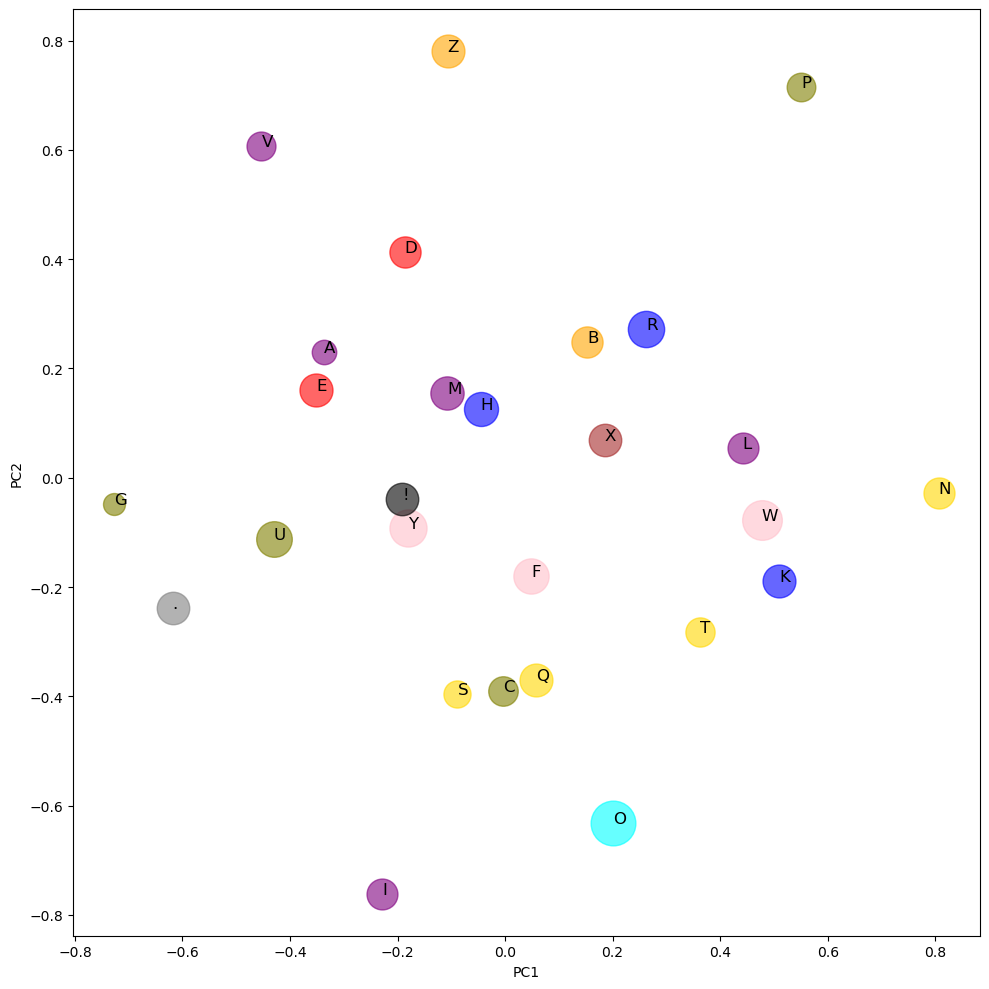

In [274]:
plt.figure(figsize=(10,10))
plt.xlabel('PC1')
plt.ylabel('PC2')
for idx in itos.keys():
    plt.scatter(vis[idx,0], vis[idx,1], c=cdict[aadict[itos[idx]][0]], s=aadict[itos[idx]][1],
                alpha=0.6)
    plt.annotate(itos[idx], (vis[idx,0],vis[idx,1]), fontsize=12)
plt.tight_layout()

In [ ]:
import copy

tran2 = copy.deepcopy(tran)

In [263]:
tran2.train()
optimizer2 = torch.optim.Adam(tran.parameters(), lr=1e-5)
losses2 = []

ts2 = time.time()
te2 = time.time()
for step in range(100000):
    optimizer2.zero_grad()
    ix2 = torch.randint(0, Xtr.shape[0], (16,))
    logits2 = tran(Xtr[ix2],ytr[ix2])
    loss2 = F.cross_entropy(logits2, ytr[ix2])
    losses2.append(loss2.item())
    loss2.backward()
    optimizer2.step()
    
    if step % 50000 == 49999:
        print(f"step={step+1}, loss={loss2}, time={time.time()-te2}")
        te2 = time.time()
tf2 = time.time()
tf2-ts2

step=50000, loss=89.87505340576172, time=261.71271228790283
step=100000, loss=85.35775756835938, time=262.35343647003174


524.0666830539703

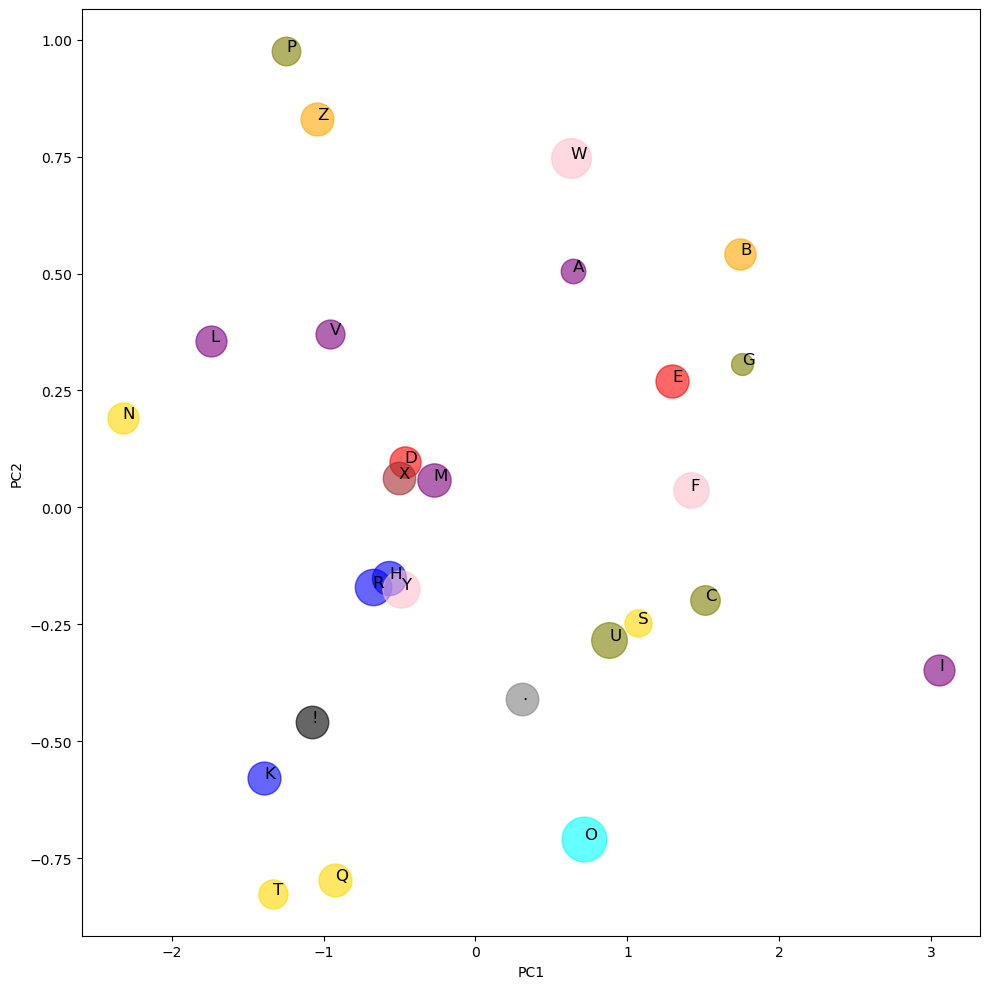

In [273]:
for p in tran2.named_parameters():
    if p[0] == 'encoder.layers.0.linear1.weight':
        w1 = p[1].detach().numpy()
    if p[0] == 'encoder.layers.0.linear2.weight':
        w2 = p[1].detach().numpy()
        weight2 = p[1].detach().numpy().T
weight2 = w1 @ w2
pca2 = PCA(n_components=2)
vis2 = pca2.fit_transform(weight2)
plt.figure(figsize=(10,10))
plt.xlabel('PC1')
plt.ylabel('PC2')
for idx in itos.keys():
    plt.scatter(vis2[idx,0], vis2[idx,1], c=cdict[aadict[itos[idx]][0]], s=aadict[itos[idx]][1],
                alpha=0.6)
    plt.annotate(itos[idx], (vis2[idx,0],vis2[idx,1]), fontsize=12)
plt.tight_layout()

In [270]:
for p in tran2.named_parameters():
    print(p[0], p[1].shape)

encoder.layers.0.self_attn.in_proj_weight torch.Size([15, 5])
encoder.layers.0.self_attn.in_proj_bias torch.Size([15])
encoder.layers.0.self_attn.out_proj.weight torch.Size([5, 5])
encoder.layers.0.self_attn.out_proj.bias torch.Size([5])
encoder.layers.0.linear1.weight torch.Size([27, 5])
encoder.layers.0.linear1.bias torch.Size([27])
encoder.layers.0.linear2.weight torch.Size([5, 27])
encoder.layers.0.linear2.bias torch.Size([5])
encoder.layers.0.norm1.weight torch.Size([5])
encoder.layers.0.norm1.bias torch.Size([5])
encoder.layers.0.norm2.weight torch.Size([5])
encoder.layers.0.norm2.bias torch.Size([5])
decoder.layers.0.self_attn.in_proj_weight torch.Size([15, 5])
decoder.layers.0.self_attn.in_proj_bias torch.Size([15])
decoder.layers.0.self_attn.out_proj.weight torch.Size([5, 5])
decoder.layers.0.self_attn.out_proj.bias torch.Size([5])
decoder.layers.0.multihead_attn.in_proj_weight torch.Size([15, 5])
decoder.layers.0.multihead_attn.in_proj_bias torch.Size([15])
decoder.layers.0.m